# TSP
Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowa-
nego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punk-
tów.
a) Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3
różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema
różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
b) Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary
swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.
c) Przedstaw wizualizację (saoptimset) działania procedury minimalizującej funkcję
celu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from matplotlib.animation import FuncAnimation, PillowWriter


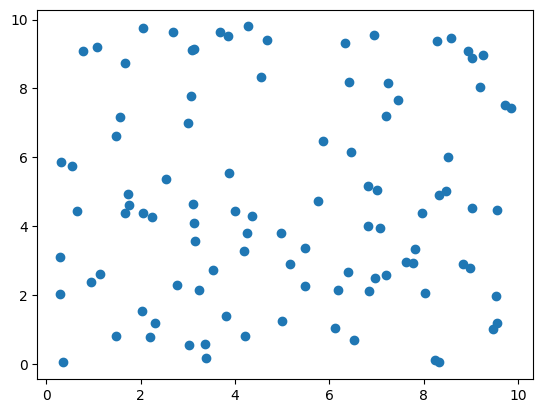

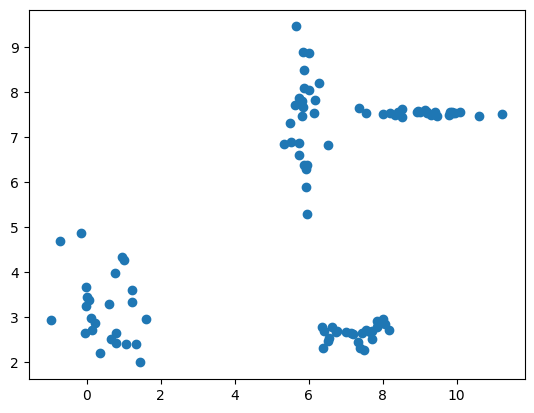

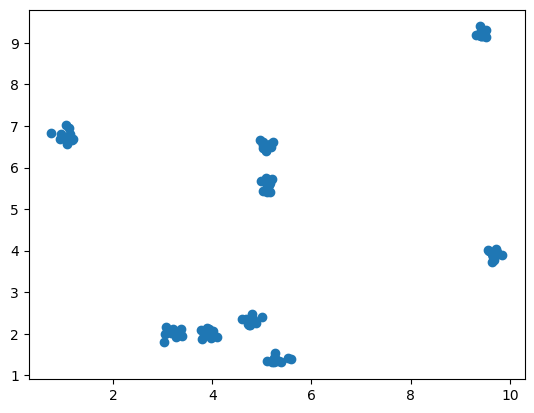

In [2]:
def generate_points(n, distribution='uniform'):
    if distribution == 'uniform':
        return np.random.uniform(0, 10, (n, 2))
    elif distribution == 'normal':
        params = [
            (np.random.uniform(0, 10), np.random.uniform(0, 10), np.random.uniform(0, 1), np.random.uniform(0, 1)),
            (np.random.uniform(0, 10), np.random.uniform(0, 10), np.random.uniform(0, 1), np.random.uniform(0, 1)),
            (np.random.uniform(0, 10), np.random.uniform(0, 10), np.random.uniform(0, 1), np.random.uniform(0, 1)),
            (np.random.uniform(0, 10), np.random.uniform(0, 10), np.random.uniform(0, 1), np.random.uniform(0, 1)),
        ]
        points = []
        for mean_x, mean_y, std_x, std_y in params:
            points.append(np.random.normal([mean_x, mean_y], [std_x, std_y], (n // 4, 2)))
        return np.concatenate(points)
    elif distribution == 'groups':
        points = []
        for i in range(9):
            middle = np.random.uniform(0, 10, 2)
            points.append(np.random.normal(middle, 0.1, (n // 9, 2)))
        return np.concatenate(points)


def draw_points(points, label=None):
    plt.scatter(points[:, 0], points[:, 1], label=label)
    plt.show()


draw_points(generate_points(100, 'uniform'), 'uniform')
draw_points(generate_points(100, 'normal'), 'normal')
draw_points(generate_points(100, 'groups'), 'groups')


In [3]:
def visualize_route_history(points, route_history, title, output_filename):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Print debug info
    print(f"Visualizing {len(route_history)} frames")
    print(f"Route lengths: {[len(route) for route in route_history[:3]]}...")

    def update(frame):
        ax.clear()
        route = route_history[frame]

        # Connect points in the route order
        route_points = points[route]
        # Add the first point at the end to close the loop
        path = np.vstack([route_points, route_points[0]])

        # Plot points
        ax.scatter(points[:, 0], points[:, 1], c='blue', s=40)

        # Plot the path
        ax.plot(path[:, 0], path[:, 1], 'r-')

        # Use actual frame number, not scaled by 100
        ax.set_title(f"{title} - Frame: {frame}")
        ax.set_xlim(np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1)
        ax.set_ylim(np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)

        return ax,

    # Create animation with proper interval
    ani = FuncAnimation(fig, update, frames=len(route_history),
                        interval=200, blit=False)

    try:
        writer = PillowWriter(fps=5)
        ani.save(f"ex1img/{output_filename}.gif", writer=writer)
        print(f"Animation saved to {output_filename}.gif")
    except Exception as e:
        print(f"Error saving animation: {str(e)}")

    display(HTML(ani.to_jshtml()))
    print(f"Animation saved as {output_filename}.gif")
    return ani

In [4]:
def distance_between(p1, p2):
    return np.sqrt(np.pow(p2[0] - p1[0], 2) + np.pow(p2[1] - p1[1], 2))


def calculate_distance(points, s):
    distance = 0
    for i in range(len(s) - 1):
        p1 = points[s[i]]
        p2 = points[s[i + 1]]
        distance += distance_between(p1, p2)
    return distance


def change_neighbours(s, type="consecutive"):
    s_tmp = s[:]
    if type == "consecutive":
        i = np.random.randint(0, len(s) - 1)
        s_tmp[i], s_tmp[i + 1] = s_tmp[i + 1], s_tmp[i]
    else:
        i = np.random.randint(0, len(s))
        j = np.random.randint(0, len(s))
        s_tmp[i], s_tmp[j] = s_tmp[j], s_tmp[i]

    return s_tmp


def linear(temp, k, a=0.95, delta = 1):
    return temp - delta


def geometric(temp, k, a=0.95, delta = 1):
    return temp * a


def logarithmic(temp, k, a=0.95, delta = 1):
    return temp / np.log(k + 1)


def tsp(temperature, cooling_function, points, min_temperature, random_type="uniform",  neighbour_type="consecutive", function="f1"):
    s = [i for i in range(len(points))]
    np.random.shuffle(s)

    delta = temperature / 10000

    iteration = 1
    chosen_worse = 1
    route_history = [s.copy()]
    best_result_changelog = []


    while temperature > min_temperature:
        new_s = change_neighbours(s, neighbour_type)
        difference = calculate_distance(points, new_s) - calculate_distance(points, s)
        if difference < 0 or np.random.random() < np.exp(- difference / temperature):
            s = new_s
            best_result_changelog.append(calculate_distance(points, s))

        else:
            chosen_worse += 1



        temperature = cooling_function(temperature, iteration, delta=delta)

        route_history.append(s.copy())
        iteration += 1
        # print(temperature)

    # plot for best result
    plt.figure(figsize=(10, 6))
    plt.plot(best_result_changelog)
    plt.title(f"tsp t:{random_type} n:{neighbour_type} f:{function}")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.show()


    n = len(route_history)
    max_frames = 50
    if n <= max_frames:
        route_history_to_gif = route_history
    else:
        indices = np.linspace(0, n - 1, max_frames, dtype=int)
        route_history_to_gif = [route_history[i] for i in indices]



    output_filename = f"tsp_{random_type}_{neighbour_type}_{function}"
    print(f"Creating animation with {len(route_history)} frames...")
    visualize_route_history(points, route_history_to_gif, f"TSP t:{random_type} n:{neighbour_type} f:{function}",
                            output_filename)

    print(f"iterations: {iteration}")
    print(f"chosen worse: {chosen_worse}")
    return s, route_history



In [5]:
def main():
    n = 100
    temperature = 10000
    min_temperature = 1


    points = generate_points(n, 'groups')
    tsp(temperature, linear, points, min_temperature, "groups", "consecutive", "linear")

    points = generate_points(n, 'uniform')
    tsp(temperature, linear, points, min_temperature, "uniform", "consecutive", "linear")

    points = generate_points(n, 'normal')
    tsp(temperature, linear, points, min_temperature, "normal", "consecutive", "linear")

    points = generate_points(n, 'groups')
    tsp(temperature, geometric, points, min_temperature, "groups", "arbitrary", "geometric")

    points = generate_points(n, 'uniform')
    tsp(temperature, geometric, points, min_temperature, "uniform", "arbitrary", "geometric")

    points = generate_points(n, 'normal')
    tsp(temperature, geometric, points, min_temperature, "normal", "arbitrary", "geometric")

    points = generate_points(n, 'groups')
    tsp(temperature, logarithmic, points, min_temperature, "groups","consecutive",  "logarithmic")

    points = generate_points(n, 'uniform')
    tsp(temperature, logarithmic, points, min_temperature, "uniform","consecutive", "logarithmic")

    points = generate_points(n, 'normal')
    tsp(temperature, geometric, points, min_temperature, "normal", "consecutive", "geometric")

    points = generate_points(n, 'groups')
    tsp(temperature, geometric, points, min_temperature, "groups", "arbitrary", "geometric")

    points = generate_points(n, 'uniform')
    tsp(temperature, geometric, points, min_temperature, "uniform", "arbitrary", "geometric")

    points = generate_points(n, 'normal')
    tsp(temperature, geometric, points, min_temperature, "normal", "arbitrary", "geometric")


main()





KeyboardInterrupt

